<a href="https://colab.research.google.com/github/Maysarah-eltamalawi/Computer-vision-assignment/blob/main/Genetic_algorithm_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Please scroll through and make sure all libraries are available, especially pandas and panda3d, as the runtime is about 15 minutes
#For the visualization, the finish line is straight ahead, just keep moving forward!
import numpy as np
import random as rd
import math
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
no_Dv = 3
n_pop = 100
ub = np.array ([200,150,100])
lb = np.array ([10,10,10])
BestSolution = np.array ([0,0,0])
visual = np.array([0,0,0])

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
# Load data
driving_cycle = pd.read_excel('DriveCycle.xlsx') #Please insert the file path
driving_cycle.head(10)

,Car.ax,Car.ay,Car.v,Time,SOC,A
0,-0.152787,-0.135081,0.000203,0.001,0.999990,0.000203
1,-0.042909,-0.013671,0.010553,0.101,0.998991,0.010350
2,-0.013100,0.022345,0.012579,0.201,0.997992,0.002026
3,-0.003713,0.027647,0.012644,0.301,0.996995,0.000064
4,-0.002412,0.009769,0.012840,0.401,0.995998,0.000196
5,-0.001906,-0.004807,0.013053,0.501,0.995003,0.000213
6,-0.001871,-0.005577,0.013232,0.601,0.994008,0.000179
7,-0.001895,0.005298,0.013421,0.701,0.993015,0.000189
8,-0.001916,0.013552,0.013631,0.801,0.992022,0.000210
9,-0.001924,0.013407,0.013970,0.901,0.991030,0.000339


In [ ]:
def maxP():
    #The following section calculates the largest possible power required within the driving cycle
    #It is used to constrain the decision variables
    j=0
    vTemp=0
    aTemp=0
    while j <2000:
        if vTemp<driving_cycle['Car.v'][j]:
            vTemp= driving_cycle['Car.v'][j]

        A=math.sqrt(driving_cycle['Car.ax'][j]**2 + driving_cycle['Car.ay'][j]**2)
        if aTemp<A:
            aTemp= A
        j=j+1

    Ptotal1DC= (vTemp/3600*0.85)*(1400*9.81*(0.0076+0.000056*vTemp)+(0.47*3.3*(vTemp**2))/21.15)
    Ptotal2DC= (vTemp/3600*0.85)*(1400*9.81*((0.0076+0.000056*vTemp)*math.cos(3*math.pi/180)+math.sin(3*math.pi/180))+(0.47*3.3*vTemp**2)/21.15)
    Ptotal3DC= (vTemp/3600*0.85)*(1400*9.81*(0.0076+0.000056*vTemp)+((0.47*3.3*(vTemp**2))/21.15)+(1400*0.07*aTemp)/3.6)
    PmaxDC= max(Ptotal1DC,Ptotal2DC,Ptotal3DC)
    return PmaxDC

In [ ]:
def obj(curr):
#han7ot el DVs fe array

    i = 2
    while i<2000 :
        Pe=curr[0]
        Pm=curr[1]
        Q0=curr[2]
        totalDistance = 5000
        SOC = (10**-2)*driving_cycle['SOC'][i]
        V= driving_cycle['Car.v'][i]
        G=3*math.pi/180
        mf=0
        A=math.sqrt(driving_cycle['Car.ax'][i]**2+driving_cycle['Car.ay'][i]**2)
        time = driving_cycle['Time'][i]

####

        OCV=2.85+(4.8*SOC)-(17.8*(SOC)**2)+(38.59*(SOC)**3)+(4.91*(SOC)**4)-(210.52*(SOC)**5)+(433.98*(SOC)**6)-(368.45* (SOC)**7)+(115.81*(SOC)**8)
        FCe=((1-SOC)**2*Q0*3600*OCV)/279673588*0.85*0.85
        DistE= (Q0/FCe)*10**-1

#####

        Ptotal1= (V/3600*0.85)*(1400*9.81*(0.0076+0.000056*V)+(0.47*3.3*V**2)/21.15)
        Ptotal2= (V/3600*0.85)*(1400*9.81*((0.0076+0.000056*V)*(math.cos(G))+math.sin(G))+(0.47*3.3*V**2)/21.15)
        Ptotal3= (V/3600*0.85)*(1400*9.81*(0.0076+0.000056*V)+(0.47*3.3*V**2)/21.15+1400*0.07*(A/3.6))
        Pinst= max(Ptotal1,Ptotal2,Ptotal3)
        mf= mf + (Pinst*225)/367.1*0.84*9.81
        i=i+1

    #Evaluating Objective Functions post drive cycle
    #Mapping individual functions between 0-1 results in a 0-3 ranged Total objective function for fair weights
    Totalmf=mf/time
    TotalCost=(12*Pe+424)+(14*Pm+190)+(8*10*Q0+650)
    TCostMapped= (TotalCost - 2324) / 11440
    UF= DistE/totalDistance
    FC= (Totalmf+FCe)/((10**-5)*0.84*totalDistance)
    FCMapped= (FC - 1.7) / 0.6
    visual2=[FC,UF,TotalCost]
    Total_objective= FCMapped + TCostMapped + (1/UF)
    return visual2,Total_objective

In [ ]:
def is_feasible(curr):
  x = curr[0] < ub[0]
  y= curr[1] < ub[1]
  w= curr[0]+curr[1] > maxP()*2 #Using a safety margin by doubling the maximum power required by the drive cycle
  z = x & y & w
  return z

In [ ]:
def init_random_solution():
  x = np.random.rand(no_Dv) * (ub - lb) + lb
  if not(is_feasible(x)):
    x = init_random_solution();
  return x

In [ ]:
def initRandomPopulation():
   Rd_pop = []
   Rdpop_fvalues = []
   best_sol = []
   best_fvalues = []
   for i in range(n_pop):
       new_sol = init_random_solution()
       visual,new_objvalue = obj(new_sol)
       Rd_pop.append(new_sol)
       Rdpop_fvalues.append(new_objvalue)
       if len(best_sol) == 0:
          best_sol.append(new_sol)
          best_fvalues.append(new_objvalue)
       elif (new_objvalue < best_fvalues[0]):
          best_sol[0], best_fvalues[0] = new_sol, new_objvalue
   return Rd_pop, Rdpop_fvalues, best_sol, best_fvalues

In [ ]:
omar = [1000,50,500,6065]
np.argsort(omar)

array([1, 2, 0, 3], dtype=int64)

In [ ]:
def selectParentsC(n_pop, numParents):
  parents_idx = np.random.choice(n_pop, numParents, replace=False)
  return parents_idx

In [ ]:
def selectParentsM(n_pop, numParents, gen_fvalues):
   parents_idx = np.argsort(gen_fvalues)[n_pop-numParents:]
   return parents_idx


In [ ]:
def selectSurvivors(pop_obj, numSurvivors):
        survivors_idx = np.argsort(pop_obj)[:numSurvivors]
        return survivors_idx

In [ ]:
def mutation(pop, p_idx):
    # Random noise
    r = np.random.rand(no_Dv)
    child = pop[p_idx] + r * (ub - pop[p_idx]) + (1 - r) * (lb - pop[p_idx])
    if not(is_feasible(child)):
      child = mutation(pop, p_idx)
    return child

In [ ]:
def crossover(pop, p1_idx, p2_idx):
        # Whole Arithmetic Combination
        alpha = np.random.rand() * (0.9 - 0.7) + 0.7
        child1 = alpha * pop[p1_idx] + (1 - alpha) * pop[p2_idx]
        child2 = (1 - alpha) * pop[p1_idx] + alpha * pop[p2_idx]
        return child1, child2

In [ ]:
def GA(n_pop = 100, max_iter = 100, p_elite = 0.1, p_crossover = 0.6, p_mutation = 0.3):
    pop,fvalues,bestsol, best_fvalues = initRandomPopulation()
    print("Best Initial Solution ", best_fvalues[0])
    n_crossovers = int(np.ceil(p_crossover * n_pop / 2))
    n_mutations = int(p_mutation * n_pop)
    n_elite = int(p_elite * n_pop)
    n_survivors = n_pop - int(p_crossover*n_pop) - n_mutations - n_elite
    for _ in range(max_iter):
        # Crossover and Parents Selection
        parents_idx = selectParentsC(n_pop, numParents = n_crossovers*2)
        new_pop = []
        new_fvalues = []
        for i in range(0, n_crossovers*2, 2):
            [ch1, ch2] = crossover(pop, parents_idx[i], parents_idx[i+1])
            new_pop.append(ch1)
            visual,NObj=obj(ch1)
            new_fvalues.append(NObj)
            if len(new_pop) == int(p_crossover * n_pop):
                break
            new_pop.append(ch2)
            visual,NObj2=obj(ch2)
            new_fvalues.append(NObj2)

        # Mutation and Parents Selection
        parents_idx = selectParentsM(n_pop,n_mutations, fvalues)
        for i in range(n_mutations):
            ch = mutation(pop,parents_idx[i])
            new_pop.append(ch)
            visual,NobjCH=obj(ch)
            new_fvalues.append(NobjCH)

        # Elite Members
        # elite_idx = selectSurvivors(n_pop, numSurvivors=n_elite)
        elite_idx = np.argsort(fvalues)[:n_elite]
        for i in range(n_elite):
            new_pop.append(pop[elite_idx[i]])
            new_fvalues.append(fvalues[elite_idx[i]])

        # Survivors (if any)
        survivors_idx = selectSurvivors(fvalues, n_survivors)
        for i in range(n_survivors):
            new_pop.append(pop[survivors_idx[i]])
            new_fvalues.append(fvalues[survivors_idx[i]])
        assert(len(new_pop) == n_pop)
        assert(len(new_fvalues) == n_pop)
        pop = new_pop
        fvalues = new_fvalues

        # update best solution reached so far
        best_idx = np.argmin(fvalues)
        if fvalues[best_idx] < best_fvalues[-1]:
            bestsol.append(pop[best_idx])
            best_fvalues.append(fvalues[best_idx])
        else:
            bestsol.append(bestsol[-1])
            best_fvalues.append(best_fvalues[-1])

        print("Iteration:",format(_))
        print("Best:",format(round(best_fvalues[-1],5)))

    return visual, bestsol,best_fvalues

In [ ]:
visual, best_array, best_objective=GA()
BestSolution = best_array[-1]

Best Initial Solution  1.8678778640344023
Iteration: 0
Best: 1.86788
Iteration: 1
Best: 1.86788
Iteration: 2
Best: 1.86788
Iteration: 3
Best: 1.86788
Iteration: 4
Best: 1.86788
Iteration: 5
Best: 1.86788
Iteration: 6
Best: 1.86788
Iteration: 7
Best: 1.86788
Iteration: 8
Best: 1.86788
Iteration: 9
Best: 1.83852
Iteration: 10
Best: 1.83852
Iteration: 11
Best: 1.83852
Iteration: 12
Best: 1.83852
Iteration: 13
Best: 1.83852
Iteration: 14
Best: 1.83852
Iteration: 15
Best: 1.83852
Iteration: 16
Best: 1.83852
Iteration: 17
Best: 1.83852
Iteration: 18
Best: 1.83852
Iteration: 19
Best: 1.83852
Iteration: 20
Best: 1.83852
Iteration: 21
Best: 1.83852
Iteration: 22
Best: 1.83852
Iteration: 23
Best: 1.83852
Iteration: 24
Best: 1.83852
Iteration: 25
Best: 1.83852
Iteration: 26
Best: 1.83852
Iteration: 27
Best: 1.83852
Iteration: 28
Best: 1.83852
Iteration: 29
Best: 1.83852
Iteration: 30
Best: 1.83852
Iteration: 31
Best: 1.83852
Iteration: 32
Best: 1.83852
Iteration: 33
Best: 1.83852
Iteration: 34
Be

In [ ]:
print(best_objective[-1])
print(best_array[-1])

1.7994986132624946
[31.94522536 12.81054799 10.51721128]


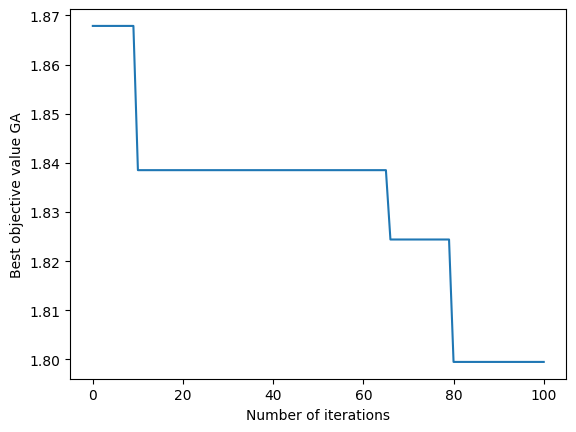

In [ ]:
import matplotlib.pyplot as plt
plt.plot(best_objective)
plt.ylabel('Best objective value GA')
plt.xlabel('Number of iterations')
plt.show()

In [ ]:
#The following is the visualization code
#You will be simulating a drive cycle to test out the algorithm's proposed solution
#Once you reach the finish line, your data analysis will be complete

from direct.showbase.ShowBase import ShowBase
from panda3d.core import *
from direct.gui.OnscreenText import OnscreenText
from direct.actor.Actor import Actor
import random
import sys
import os
import math

conf = """"
win-size 1280 720
window-title My Game
show-frame-rate-meter True"""

In [ ]:
#Game Instructions
def addInstructions(pos, msg):
    return OnscreenText(text=msg, style=1, fg=(1, 1, 1, 1), scale=.05,
                        shadow=(0, 0, 0, 1), parent=base.a2dTopRight,
                        pos=(-0.05, -pos - 0.05), align=TextNode.ARight)

In [ ]:
def addTitle(text):
    return OnscreenText(text=text, style=1, fg=(1, 1, 1, 1), scale=.07,
                        parent=base.a2dTopLeft, align=TextNode.ALeft,
                        pos=(0, -0.09), shadow=(0, 0, 0, 1))

In [ ]:
class Visualization(ShowBase):
    # Records the state of the arrow keys
    def setKey(self, key, value):
        self.keyMap[key] = value

    def __init__(self):
        ShowBase.__init__(self)
        self.win.setClearColor((0, 0, 0, 1))
        self.keyMap = {
            "left": 0, "right": 0, "forward": 0, "down": 0, "cam-left": 0, "cam-right": 0}

        self.title = addTitle(
            "Please Advance Forward to the Finish Line")
        self.inst1 = addInstructions(0.12, "[Down Arrow]: Reverse")
        self.inst2 = addInstructions(0.18, "[Left Arrow]: Rotate Left")
        self.inst3 = addInstructions(0.24, "[Right Arrow]: Rotate Right")
        self.inst4 = addInstructions(0.06, "[Up Arrow]: Run Forward")

        self.environ = loader.loadModel("myModels/city/scene.gltf") #Edit path if needed
        self.environ.setH(90)
        self.environ.setPos(2500,16700,-180)
        self.environ.setScale(0.35,0.35,0.35)
        self.environ.reparentTo(render)

        self.environ2 = loader.loadModel("myModels/city2/scene.gltf") #Edit path if needed
        self.environ2.setPos(0,2700,-170)
        self.environ2.setScale(1.3,1.3,1.3)
        self.environ2.reparentTo(render)

        self.environ3 = loader.loadModel("myModels/city3/scene.gltf") #Edit path if needed
        self.environ3.setH(180)
        self.environ3.setPos(35,19500,-50)
        self.environ3.setScale(100,100,100)
        self.environ3.reparentTo(render)

        self.ralph = Actor("myModels/scene.gltf") #Edit path if needed
        self.ralph.setH(180)
        self.ralph.setScale(50,50,50)
        self.ralph.setPos(0, 600, -170)
        self.ralph.reparentTo(render)

        self.floater = NodePath(PandaNode("floater"))
        self.floater.reparentTo(self.ralph)
        self.floater.setZ(2)

        self.accept("escape", sys.exit)
        self.accept("arrow_left", self.setKey, ["left", True])
        self.accept("arrow_right", self.setKey, ["right", True])
        self.accept("arrow_up", self.setKey, ["forward", True])
        self.accept("arrow_down", self.setKey, ["down", True])
        self.accept("a", self.setKey, ["cam-left", True])
        self.accept("s", self.setKey, ["cam-right", True])
        self.accept("arrow_left-up", self.setKey, ["left", False])
        self.accept("arrow_right-up", self.setKey, ["right", False])
        self.accept("arrow_up-up", self.setKey, ["forward", False])
        self.accept("arrow_down-up", self.setKey, ["down", False])
        self.accept("a-up", self.setKey, ["cam-left", False])
        self.accept("s-up", self.setKey, ["cam-right", False])

        taskMgr.add(self.move, "moveTask")
        self.isMoving = False

        # Set up the camera
        #self.disableMouse()
        self.camera.setPos(0, 1150,0)


        ambientLight = AmbientLight("ambientLight")
        ambientLight.setColor((.5, .5, .5, 1))
        directionalLight = DirectionalLight("directionalLight")
        directionalLight.setDirection((-5, -5, -5))
        directionalLight.setColor((1, 1, 1, 1))
        directionalLight.setSpecularColor((1, 1, 1, 1))
        render.setLight(render.attachNewNode(ambientLight))
        render.setLight(render.attachNewNode(directionalLight))

    def move(self, task):
        # Get the time that elapsed since last frame.  We multiply this with
        # the desired speed in order to find out with which distance to move

        dt = globalClock.getDt()

        # If a move-key is pressed, move your car in the specified direction.
        if self.keyMap["left"]:
            self.ralph.setH(self.ralph.getH() + 70 * dt)
        if self.keyMap["right"]:
            self.ralph.setH(self.ralph.getH() - 70 * dt)
        if self.keyMap["forward"]:
            self.ralph.setY(self.ralph, -25 * dt)
        if self.keyMap["down"]:
            self.ralph.setY(self.ralph, +25 * dt)

        if(self.ralph.getY()>19500):
            x=round(visual[0],2)
            FC="Fuel Consumption throughout trip: {}L \n".format(x)
            y=round(visual[1],2)
            uf="Utility Factor Obtained: {} \n".format(y)
            z=round(visual[2],2)
            cost="Total Powertrain Cost: ${} \n\n".format(z)
            opt="The proposed near optimal solution is:\n"
            powerenginevalue=round(BestSolution[0],2)
            pengine="Engine Power: {}kW \n".format(powerenginevalue)
            powermotorvalue=round(BestSolution[1],2)
            pmotor="Electric Motor Power: {}kW \n".format(powermotorvalue)
            batcapvalue=round(BestSolution[2],2)
            batterycap="Battery Capacity: {}kWh \n\n".format(batcapvalue)
            text=TextNode('Drive Cycle ended')
            text.setText(opt+pengine+pmotor+batterycap+
            "You have finished a Drive Cycle for the solution!\n"+FC+uf+cost)
            text.setAlign(TextNode.ACenter)
            text.setSlant(.2)
            text.setTextColor(0,0,0,1)
            textNodePath = aspect2d.attachNewNode(text)
            textNodePath.setScale(0.1)
            text.setCardColor(0.7, 0.7, 0.7, 1)
            text.setCardAsMargin(100, 100, 100, 100)
            text.setCardDecal(True)

        if self.keyMap["forward"] or self.keyMap["left"] or self.keyMap["right"] or self.keyMap["down"]:
            if self.isMoving is False:
                self.isMoving = True
        else:
            if self.isMoving:
                self.ralph.stop()
                self.isMoving = False


        camvec = self.ralph.getPos() - self.camera.getPos()
        camvec.setZ(0)
        camdist = camvec.length()
        camvec.normalize()
        if camdist > 600.0:
            self.camera.setPos(self.camera.getPos() + camvec * (camdist - 600))
            camdist = 600.0
        if camdist < 500.0:
            self.camera.setPos(self.camera.getPos() - camvec * (500 - camdist))
            camdist = 500.0

        self.camera.lookAt(self.floater)

        return task.cont

In [ ]:
myGame = Visualization()
myGame.run()

SystemExit: 

D:\Anaconda3\envs\GUCMechatronics\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
